In [1]:
import xarray as xr
import numpy as np
import datetime
import pandas as pd
import gsw
from scipy import interpolate

import matplotlib as mpl
import matplotlib.pyplot as plt


Here dictionaries

In [2]:
################################################################################
########    DICTIONARIES
################################################################################

reg_ext = {
    'lab': {
        'lon' : (-60, -30),
        'lat' : (50, 65),
        'name' : 'Labrador and Irminger Seas'
    },
    'gul': {
        'lon' : (-75, -45),
        'lat' : (30, 45),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-30, -5),
        'lat' : (45, 60),
        'name' : 'North East Sea'
    }
}

## Selected points in the regions
### Gulf S: (60W, 35N)
### Lab -I: (50W, 55N)
### Nor E: (17.5W, 52.5N)
points = {
    'gul': {
        'lon': -55., 
        'lat': 36.
    },
    'lab': {
        'lon': -53., 
        'lat': 58.
    },
    'irm': {
        'lon': -37., 
        'lat': 60.
    },
    'noe': {
        'lon': -17.5, 
        'lat': 52.5}
}

gulf = {
    12 : {
        't': (17.5, 19.), 
        's': (36.45, 36.65),
        'd': (26.3, 26.65)
    },
    25 : {
        't': (17.5, 25.), 
        's': (36.25, 36.75),
        'd': (24., 27.)
    },
    38 : {
        't': (17.5, 26.), 
        's': (36.4, 36.8),
        'd': (24., 26.5)
    },
    51 : {
        't': (18., 22.2), 
        's': (36.4, 36.7),
        'd': (25., 26.5)
    }
}


labrador = {
    12 : {
        't': (2.75, 3.5), 
        's': (34.65, 34.85),
        'd': (27.6, 27.75)
    },
    25 : {
        't': (3., 8.), 
        's': (34.5, 35.),
        'd': (26., 29.)
    },
    38 : {
        't': (3., 11.), 
        's': (34.5, 35.),
        'd': (26., 28.)
    },
    51 : {
        't': (4., 5.5), 
        's': (34.25, 35.),
        'd': (27.2, 27.7)
    }
}


north = {
    12 : {
        't': (10.7, 11.7), 
        's': (35.35, 35.5),
        'd': (26.9, 27.3)
    },
    25 : {
        't': (10., 15.), 
        's': (35.3, 35.7),
        'd': (26.2, 27.2)
    },
    38 : {
        't': (11., 16.), 
        's': (35.3, 35.7),
        'd': (26., 28.)
    },
    51 : {
        't': (11., 13.), 
        's': (35.45, 35.65),
        'd': (26.8, 27.2)
    }
}


mld_lines = {
    'MLDa' : {
        'color' : 'k',
        'linestyle' :'solid', 
        'linewidth' : 3
    },
    'MLDf' : {
        'color' : 'm', 
        'linestyle' : 'solid', 
        'linewidth' : 3
    },
    'MLDv' : {
        'color' : 'c', 
        'linestyle' : 'solid', 
        'linewidth' : 1
    },
    'MLDint' : {
        'color' : 'r', 
        'linestyle' : 'dashdot', 
        'linewidth' : 2
    }
}

Here we have the fucntions

In [3]:
################################################################################
########    FUNCTIONS
################################################################################

## Function to make the (x,y)-> (lon,lat) grid
def Grid(data_set):
    """
        Grid is a function that creates a rectangular grid using as x a longitude
        array and for y a latitude array.
        
        Parameters:
        ------------
            
        data_set : DataArray
            Is the dataset from which we will plot the histogram.
        
        Output:
        -------
        (x, y) : n-arrays
            Arrays that correspond for each (lon,lat) point
    """
    x = data_set.longitude
    y = data_set.latitude
    
    x, y = np.meshgrid(x, y)
    return(x, y)



## Function to crop the dataset
def Crops(coord, d_set):
    """
        Crops is a function that takes a data set and crops it into smaller
        region, using as parameters the values given by the dictionary 
        reg_ext.
        
        Parameters:
        ------------
            
        coord : string
            Key value that identifies the region to obtain
        
        d_set : DataArray
            Dataset to be cropped
        
        Output:
        -------
        new_ds : DataArray
            New data array corresponding to the region stated by 'coord'
    """
    
    lon1, lon2 = reg_ext[coord]['lon']
    lat1, lat2 = reg_ext[coord]['lat']
    name_fig = reg_ext[coord]['name']
    
    new_ds = d_set.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2))
    return(new_ds)


def Limits(dictionary, t):
    a = dictionary[t]['t']
    b = dictionary[t]['s']
    c = dictionary[t]['d']
    
    return(a, b, c)

def Convert(data_set, t):
    dep = - data_set.depth
    sal = data_set.so[t].values
    tem = data_set.to[t].values
    lon = float(data_set.longitude.values)
    lat = float(data_set.latitude.values)
    
    # Pressure -> depth latitudde
    pr = gsw.p_from_z(dep, lat)
    sa = gsw.conversions.SA_from_SP(sal, pr, lon, lat)
    ct = gsw.conversions.CT_from_t(sa, tem, pr)
    ds = gsw.density.sigma0(sa, ct)

    return(dep, sa, ct, ds, pr)


def New_density(tem_10, sal_10, pss_10):
    pot_10 = gsw.pt0_from_t(sal_10, tem_10, pss_10)
    dpt = pot_10 - 0.2

    tem_02 = gsw.conversions.CT_from_pt(sal_10, dpt)
    ds_02 = gsw.density.sigma0(sal_10, tem_02)

    return (ds_02, tem_02)


def Point(data_set, coord):
    point = data_set.sel(longitude=points[coord]['lon'], 
           latitude=points[coord]['lat'], method='nearest')
    return(point)


#Function to calculate MLD, according to a threshold value
def ML_depth(depth, density, delta):

    for i in range(2, len(density)):
        diff = density[i] - density[1]
#        print(diff)

        if (diff >= delta):
            return(float(depth[i]), i)
            break

            

def Densities_delta(den, tem, sal, pss, t):
    # Calculating the density at dT = 0.2 degrees
    # pot temp_10, sal_10m -> New density at dT = 0.2
    den10 = den[1]
    tem10 = tem[1]
    sal10 = sal[1]
    pre10 = pre[1]

    den02, tem02 = New_density(tem10, sal10, pre10)
    dDv = den02 - den10
    
    return(den02, dDv)

In [65]:
################ PLOTS
## dep, tem, sal, ds_g

def Plot_density(ax, dep, tem, sal, den, depth, t=None, name=None, **mld_values):
    """
        Plot_density is a function that plots the vertical profiles of
        density, temperature and salinity. It also draws horizontal lines
        indicating the position of the MLD, given the values.    
        
        Parameters:
        ------------
            
        ax : axes.Axes object
            Current axes in which we make the draw.
            
        dep : Array
            Array with the depth coordinates. Positive going upwards.
        
        tem : Array
            Temperature [oC] profile values.
        
        sal : Array
            Salinity [PSU] profile values.
        
        depth : int
            Limit on y-axis. Given as the index of the depth array.
        
        t : int
            Number of week that corresponds to the plot. This value works together
            with the function 'Limits(reg_name, t)', retrieving the correct axis
            limits. If None, the axis imits are automatically set.
        
        name : string
            Saving name for the output plot. It is recomended to include the path of 
            objective directory. If None, the plot is not saved, and just shown. 
        
        mld_values : float [kwarg]
            Is the list of the MLD estimations. To draw horizontal lines.
            
    """
    lims_t = (np.nanmin(tem[0:depth])-0.5, np.nanmax(tem[0:depth])+0.5)
    lims_s = (np.nanmin(sal[0:depth])-0.05, np.nanmax(sal[0:depth])+0.05)
    lims_d = (np.nanmin(den[0:depth])-0.2, np.nanmax(den[0:depth])+0.2)
    
    # Temperature
    color = 'orange'
    ax.set_xlabel('Temperature [$^o$C]', color=color)
    ax.set_ylabel('Depth [m]')
    ax.plot(tem, dep, color=color)
    ax.tick_params(axis='x', labelcolor=color)
    ax.set_xlim(lims_t)
    
    #xmin = tem.min(skipna=True).values
    #xmax = tem.max(skipna=True).values
    
    for mld, v in mld_values.items(): 
        cl = mld_lines[mld]['color']
        ls = mld_lines[mld]['linestyle']
        lw = mld_lines[mld]['linewidth']
        ax.hlines(v, lims_t[0], lims_t[1], colors=cl, linestyles=ls, linewidths=lw )

    # Salinity
    color = 'blue'
    ax2 = ax.twiny()
    ax2.set_xlabel('Salinity [PSU]', color=color)  
    ax2.plot(sal, dep, color=color)
    ax2.tick_params(axis='x', labelcolor=color)
    ax2.set_xlim(lims_s)
    
    # Density
    color = 'green'
    ax3 = ax.twiny()
    ax3.set_xlabel('Density [kg m$^{-3}$]', color=color)
    ax3.plot(den, dep, color=color)
    ax3.spines["top"].set_position(("axes", 1.10))
    ax3.tick_params(axis='x', labelcolor=color)
    ax3.set_xlim(lims_d)
    
    plt.ylim(dep[depth], 0)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    if name:
        plt.savefig(name)
        

In [38]:
def Year_sel(data_set, yr):
    """
        Year_sel slects an specific year from a dataset.  
        
        Parameters:
        ------------
            
        data_set : DataArray
            Array from we extract the year.
        
        yr : int
            Number of the year we want 
        
        Output:
        ------------
        y : dataArray
            DataArray containing only the data corresponding to yr
            
    """
    cond = data_set.time.dt.year.isin([yr])
    y = data_set.sel(time=cond)
    
    return(y)

def Point_sel(data_set, lon, lat, isel=True):
    """
        Point_sel selects a point given the latitude and longitude, or the 
        index of the array. The default function is using isel. If sel() wants
        to be used, the nearest method is used to select the point.
        
        
        Parameters:
        ------------
            
        data_set : DataArray
            Array from we extract the year.
        
        lon : float
            Coordinate for longitude.
        
        lat : float
            Coordinate for latitude.
        
        Output:
        ------------
        p : dataArray
            DataArray containing only the data corresponding to (lon, lat)
            
    """
    if isel:
        p = data_set.isel(longitude=lon, latitude=lat)
    else:
        p = data_set.sel(longitude=lon, latitude=lat, method='nearest')
    
    return(p)

# Description of this notebook

The main difference between this notebook and its version 1, is that in this notebook I consider the new ARMOR dataset and the profiles are drawn for the first 500 m. It is also done over a monthly mean, over 4 regions: Gulf Stream, Labrador, Irmonger and North Eeastern seas.

The new ARMOR mld is appended to the old dataset, under the same name.

It also contains a modified version of the function Plot_density, that was developed in the Extremes_verticals notebook.

In [68]:
###############################################################################
###########         MAIN PROGRAM
###############################################################################

dir_1 = '/net/krypton/data0/project/drakkar/USERS/lgarcia/data_ARMOR/'
dir_2 = '../../../New_ARMOR/'
dir_3 = '../../Vertical-prof/'

fl_n1 = 'ARMOR_*'
fl_n2 = 'NARMOR_*'


c_armor1 = xr.open_mfdataset(dir_1 + fl_n1)
c_armor2 = xr.open_mfdataset(dir_2 + fl_n2, concat_dim='time')


d1 = datetime.datetime(2005,1,1)
d2 = datetime.datetime(2018,12,20)

weeks = pd.date_range(start=d1, end=d2, freq='7D')
c_armor2.coords['time'] = (('time'), weeks)


## Calculating monthly mean
mean1 = c_armor1.groupby('time.month').mean(dim='time')
mean2 = c_armor2.groupby('time.month').mean(dim='time')

## Selected points in the regions
### Gulf S: (60W, 35N)
### Lab -I: (50W, 55N)
### Nor E: (17.5W, 52.5N)

del c_armor1
del c_armor2

/venv/py3-phyocean/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  del sys.path[0]
/venv/py3-phyocean/lib/python3.6/site-packages/xarray/backends/api.py:933: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/venv/py3-phyocean/lib/python3.6/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to 

In [69]:
d1 = datetime.datetime(2000, 1,1)
d2 = datetime.datetime(2000, 12,31)

months = pd.date_range(start=d1, end=d2, freq='M')

mean1.coords['time'] = (('time'), months)
mean2.coords['time'] = (('time'), months)

In [70]:
gul1 = Crops('gul', mean1)
gul2 = Crops('gul', mean2)

lab1 = Crops('lab', mean1)
lab2 = Crops('lab', mean2)

noe1 = Crops('noe', mean1)
noe2 = Crops('noe', mean2)



## Gulf Stream

Spring time, March

In [83]:
gul1_p = Point(gul1, 'gul')
gul2_p = Point(gul2, 'gul')
place = gulf
t = 5


In [84]:
# Convert(data_set, t) -> (dep, sal, tem, den, temp_pot)
dep, sal, tem, den, pre = Convert(gul1_p, t)

## Calculating the deltas
dn02_gl, Ddv_gl = Densities_delta(den, tem, sal, pre, t)
Ddf_gl = 0.03

MLD_a = gul2_p.mlotst[t].values
MLD_f, jf = ML_depth(dep, den, Ddf_gl)
MLD_v, jv = ML_depth(dep, den, Ddv_gl)

# Calculating depth from density :: Interpolation
x = den[jv-1:jv+2]
y = dep[jv-1:jv+2]
dep_dens = interpolate.interp1d(x, y, kind='linear')

MLD_int = dep_dens(dn02_gl)
print("MDL by ARMOR: % 5.2f" %(MLD_a))
print("MDL fixed: % 5.2f" %(MLD_f))
print("MDL by variable: % 5.2f" %(MLD_v))
print("MDL by variable+interpolation: % 5.2f" %(MLD_int))


mld_values =  {'MLDa' : - MLD_a}

## reg_name:: gulf, labrador, north

## Making plot
#name_fig = dir_2 + 'Gulf-'+ str(t)+'.png'

/venv/py3-phyocean/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/venv/py3-phyocean/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


MDL by ARMOR:  15.63
MDL fixed: -20.00
MDL by variable: -20.00
MDL by variable+interpolation: -16.41


/venv/py3-phyocean/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


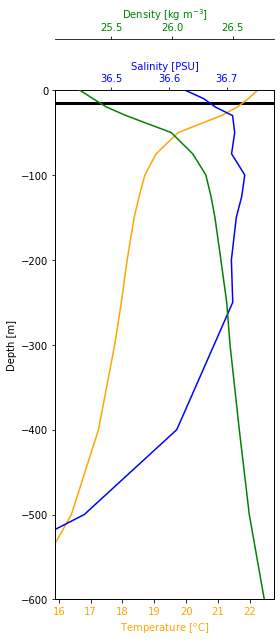

In [85]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 9))
Plot_density(ax, dep, tem, sal, den, 14, t=None, name=None, **mld_values)

plt.show()

Summer time, June 29

In [ ]:
# Time step we work on:: 12, 25, 38, 51
p_gl = Point(gul1, 'gul')
place = gulf
t = 25

In [ ]:
# Convert(data_set, t) -> (dep, sal, tem, den, temp_pot)
dep, sal, tem, den, pre = Convert(gul1_p, t)

## Calculating the deltas
dn02_gl, Ddv_gl = Densities_delta(den, tem, sal, pre, t)
Ddf_gl = 0.03

MLD_a = gul2_p.mlotst[t].values
MLD_f, jf = ML_depth(dep, den, Ddf_gl)
MLD_v, jv = ML_depth(dep, den, Ddv_gl)

# Calculating depth from density :: Interpolation
x = den[jv-1:jv+2]
y = dep[jv-1:jv+2]
dep_dens = interpolate.interp1d(x, y, kind='linear')

MLD_int = dep_dens(dn02_gl)
print("MDL by ARMOR: % 5.2f" %(MLD_a))
print("MDL fixed: % 5.2f" %(MLD_f))
print("MDL by variable: % 5.2f" %(MLD_v))
print("MDL by variable+interpolation: % 5.2f" %(MLD_int))


mld_values =  {'MLDa' : - MLD_a, 'MLDf' : MLD_f, 'MLDv' : MLD_v, 'MLDint' : MLD_int}

## reg_name:: gulf, labrador, north

## Making plot
#name_fig = dir_2 + 'Gulf-'+ str(t)+'.png'

/venv/py3-phyocean/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 9))
Plot_density(ax, dep, tem, sal, den, -500., t=None, name=None, **mld_values)

plt.show()


Autumn time, September 28

In [ ]:
# Time step we work on:: 12, 25, 38, 51
p_gl = Point(gl, 'gul')
place = gulf
t = 38
print(t)

# Convert(data_set, t) -> (dep, sal, tem, den, temp_pot)
dep, sal, tem, den, pre = Convert(p_gl, t)

## Calculating the deltas
dn02_gl, Ddv_gl = Densities_delta(den, tem, sal, pre, t)
Ddf_gl = 0.03

MLD_a = p_gl.mlotst[t].values
MLD_f, jf = ML_depth(dep, den, Ddf_gl)
MLD_v, jv = ML_depth(dep, den, Ddv_gl)

# Calculating depth from density :: Interpolation
x = den[jv-1:jv+2]
y = dep[jv-1:jv+2]
dep_dens = interpolate.interp1d(x, y, kind='linear')


MLD_int = dep_dens(dn02_gl)
print("MDL by ARMOR: % 5.2f" %(MLD_a))
print("MDL fixed: % 5.2f" %(MLD_f))
print("MDL by variable: % 5.2f" %(MLD_v))
print("MDL by variable+interpolation: % 5.2f" %(MLD_int))

## Making plot
name_fig = dir_2 + 'Gulf-'+ str(t)+'.png'
Plot_density(dep, p_gl.to[t], p_gl.so[t], den, place, t, name_fig)


Winter time, December 28

In [ ]:
# Time step we work on:: 12, 25, 38, 51
p_gl = Point(gl, 'gul')
place = gulf
t = 51
print(t)

# Convert(data_set, t) -> (dep, sal, tem, den, temp_pot)
dep, sal, tem, den, pre = Convert(p_gl, t)

## Calculating the deltas
dn02_gl, Ddv_gl = Densities_delta(den, tem, sal, pre, t)
Ddf_gl = 0.03

MLD_a = p_gl.mlotst[t].values
MLD_f, jf = ML_depth(dep, den, Ddf_gl)
MLD_v, jv = ML_depth(dep, den, Ddv_gl)

# Calculating depth from density :: Interpolation
x = den[jv-1:jv+2]
y = dep[jv-1:jv+2]
dep_dens = interpolate.interp1d(x, y, kind='linear')


MLD_int = dep_dens(dn02_gl)
print("MDL by ARMOR: % 5.2f" %(MLD_a))
print("MDL fixed: % 5.2f" %(MLD_f))
print("MDL by variable: % 5.2f" %(MLD_v))
print("MDL by variable+interpolation: % 5.2f" %(MLD_int))

## Making plot
name_fig = dir_2 + 'Gulf-'+ str(t)+'.png'
Plot_density(dep, p_gl.to[t], p_gl.so[t], den, place, t, name_fig)


## North East

In [ ]:
# Time step we work on:: 12, 25, 38, 51
p_gl = Point(nr, 'noe')
place = north
t = 12

# Convert(data_set, t) -> (dep, sal, tem, den, temp_pot)
dep, sal, tem, den, pre = Convert(p_gl, t)

## Calculating the deltas
dn02_gl, Ddv_gl = Densities_delta(den, tem, sal, pre, t)
Ddf_gl = 0.03

MLD_a = p_gl.mlotst[t].values
MLD_f, jf = ML_depth(dep, den, Ddf_gl)
MLD_v, jv = ML_depth(dep, den, Ddv_gl)

# Calculating depth from density :: Interpolation
x = den[jv-1:jv+2]
y = dep[jv-1:jv+2]
dep_dens = interpolate.interp1d(x, y, kind='linear')


MLD_int = dep_dens(dn02_gl)
print("MDL by ARMOR: % 5.2f" %(MLD_a))
print("MDL fixed: % 5.2f" %(MLD_f))
print("MDL by variable: % 5.2f" %(MLD_v))
print("MDL by variable+interpolation: % 5.2f" %(MLD_int))

## Making plot
name_fig = dir_2 + 'North-'+ str(t)+'.png'
Plot_density(dep, p_gl.to[t], p_gl.so[t], den, place, t, name_fig)


In [ ]:
# Time step we work on:: 12, 25, 38, 51
p_gl = Point(nr, 'noe')
place = north
t = 25
print(t)

# Convert(data_set, t) -> (dep, sal, tem, den, temp_pot)
dep, sal, tem, den, pre = Convert(p_gl, t)

## Calculating the deltas
dn02_gl, Ddv_gl = Densities_delta(den, tem, sal, pre, t)
Ddf_gl = 0.03

MLD_a = p_gl.mlotst[t].values
MLD_f, jf = ML_depth(dep, den, Ddf_gl)
MLD_v, jv = ML_depth(dep, den, Ddv_gl)

# Calculating depth from density :: Interpolation
x = den[jv-1:jv+2]
y = dep[jv-1:jv+2]
dep_dens = interpolate.interp1d(x, y, kind='linear')


MLD_int = dep_dens(dn02_gl)
print("MDL by ARMOR: % 5.2f" %(MLD_a))
print("MDL fixed: % 5.2f" %(MLD_f))
print("MDL by variable: % 5.2f" %(MLD_v))
print("MDL by variable+interpolation: % 5.2f" %(MLD_int))

## Making plot
name_fig = dir_2 + 'North-'+ str(t)+'.png'
Plot_density(dep, p_gl.to[t], p_gl.so[t], den, place, t, name_fig)


In [ ]:
# Time step we work on:: 12, 25, 38, 51
p_gl = Point(nr, 'noe')
place = north
t = 38
print(t)

# Convert(data_set, t) -> (dep, sal, tem, den, temp_pot)
dep, sal, tem, den, pre = Convert(p_gl, t)

## Calculating the deltas
dn02_gl, Ddv_gl = Densities_delta(den, tem, sal, pre, t)
Ddf_gl = 0.03

MLD_a = p_gl.mlotst[t].values
MLD_f, jf = ML_depth(dep, den, Ddf_gl)
MLD_v, jv = ML_depth(dep, den, Ddv_gl)

# Calculating depth from density :: Interpolation
x = den[jv-1:jv+2]
y = dep[jv-1:jv+2]
dep_dens = interpolate.interp1d(x, y, kind='linear')


MLD_int = dep_dens(dn02_gl)
print("MDL by ARMOR: % 5.2f" %(MLD_a))
print("MDL fixed: % 5.2f" %(MLD_f))
print("MDL by variable: % 5.2f" %(MLD_v))
print("MDL by variable+interpolation: % 5.2f" %(MLD_int))

## Making plot
name_fig = dir_2 + 'North-'+ str(t)+'.png'
Plot_density(dep, p_gl.to[t], p_gl.so[t], den, place, t, name_fig)


In [ ]:
# Time step we work on:: 12, 25, 38, 51
p_gl = Point(nr, 'noe')
place = north
t = 51
print(t)

# Convert(data_set, t) -> (dep, sal, tem, den, temp_pot)
dep, sal, tem, den, pre = Convert(p_gl, t)

## Calculating the deltas
dn02_gl, Ddv_gl = Densities_delta(den, tem, sal, pre, t)
Ddf_gl = 0.03

MLD_a = p_gl.mlotst[t].values
MLD_f, jf = ML_depth(dep, den, Ddf_gl)
MLD_v, jv = ML_depth(dep, den, Ddv_gl)

# Calculating depth from density :: Interpolation
x = den[jv-1:jv+2]
y = dep[jv-1:jv+2]
dep_dens = interpolate.interp1d(x, y, kind='linear')


MLD_int = dep_dens(dn02_gl)
print("MDL by ARMOR: % 5.2f" %(MLD_a))
print("MDL fixed: % 5.2f" %(MLD_f))
print("MDL by variable: % 5.2f" %(MLD_v))
print("MDL by variable+interpolation: % 5.2f" %(MLD_int))

## Making plot
name_fig = dir_2 + 'North-'+ str(t)+'.png'
Plot_density(dep, p_gl.to[t], p_gl.so[t], den, place, t, name_fig)


## Labrador-Irminger Seas

In [ ]:
# Time step we work on:: 12, 25, 38, 51
p_gl = Point(lb, 'lab')
place = labrador
t = 12
print(t)

# Convert(data_set, t) -> (dep, sal, tem, den, temp_pot)
dep, sal, tem, den, pre = Convert(p_gl, t)

## Calculating the deltas
dn02_gl, Ddv_gl = Densities_delta(den, tem, sal, pre, t)
Ddf_gl = 0.03

MLD_a = p_gl.mlotst[t].values
MLD_f, jf = ML_depth(dep, den, Ddf_gl)
MLD_v, jv = ML_depth(dep, den, Ddv_gl)

# Calculating depth from density :: Interpolation
x = den[jv-1:jv+2]
y = dep[jv-1:jv+2]
dep_dens = interpolate.interp1d(x, y, kind='linear')


MLD_int = dep_dens(dn02_gl)
print("MDL by ARMOR: % 5.2f" %(MLD_a))
print("MDL fixed: % 5.2f" %(MLD_f))
print("MDL by variable: % 5.2f" %(MLD_v))
print("MDL by variable+interpolation: % 5.2f" %(MLD_int))

## Making plot
name_fig = dir_2 + 'Labrador-'+ str(t)+'.png'
Plot_density(dep, p_gl.to[t], p_gl.so[t], den, place, t, name_fig)


In [ ]:
# Time step we work on:: 12, 25, 38, 51
p_gl = Point(lb, 'lab')
place = labrador
t = 25
print(t)

# Convert(data_set, t) -> (dep, sal, tem, den, temp_pot)
dep, sal, tem, den, pre = Convert(p_gl, t)

## Calculating the deltas
dn02_gl, Ddv_gl = Densities_delta(den, tem, sal, pre, t)
Ddf_gl = 0.03

MLD_a = p_gl.mlotst[t].values
MLD_f, jf = ML_depth(dep, den, Ddf_gl)
MLD_v, jv = ML_depth(dep, den, Ddv_gl)

# Calculating depth from density :: Interpolation
x = den[jv-1:jv+2]
y = dep[jv-1:jv+2]
dep_dens = interpolate.interp1d(x, y, kind='linear')


MLD_int = dep_dens(dn02_gl)
print("MDL by ARMOR: % 5.2f" %(MLD_a))
print("MDL fixed: % 5.2f" %(MLD_f))
print("MDL by variable: % 5.2f" %(MLD_v))
print("MDL by variable+interpolation: % 5.2f" %(MLD_int))

## Making plot
name_fig = dir_2 + 'Labrador-'+ str(t)+'.png'
Plot_density(dep, p_gl.to[t], p_gl.so[t], den, place, t, name_fig)


In [ ]:
# Time step we work on:: 12, 25, 38, 51
p_gl = Point(lb, 'lab')
place = labrador
t = 38
print(t)

# Convert(data_set, t) -> (dep, sal, tem, den, temp_pot)
dep, sal, tem, den, pre = Convert(p_gl, t)

## Calculating the deltas
dn02_gl, Ddv_gl = Densities_delta(den, tem, sal, pre, t)
Ddf_gl = 0.03

MLD_a = p_gl.mlotst[t].values
MLD_f, jf = ML_depth(dep, den, Ddf_gl)
MLD_v, jv = ML_depth(dep, den, Ddv_gl)

# Calculating depth from density :: Interpolation
x = den[jv-1:jv+2]
y = dep[jv-1:jv+2]
dep_dens = interpolate.interp1d(x, y, kind='linear')


MLD_int = dep_dens(dn02_gl)
print("MDL by ARMOR: % 5.2f" %(MLD_a))
print("MDL fixed: % 5.2f" %(MLD_f))
print("MDL by variable: % 5.2f" %(MLD_v))
print("MDL by variable+interpolation: % 5.2f" %(MLD_int))

## Making plot
name_fig = dir_2 + 'Labrador-'+ str(t)+'.png'
Plot_density(dep, p_gl.to[t], p_gl.so[t], den, place, t, name_fig)

In [ ]:
# Time step we work on:: 12, 25, 38, 51
p_gl = Point(lb, 'lab')
place = labrador
t = 51
print(t)

# Convert(data_set, t) -> (dep, sal, tem, den, temp_pot)
dep, sal, tem, den, pre = Convert(p_gl, t)

## Calculating the deltas
dn02_gl, Ddv_gl = Densities_delta(den, tem, sal, pre, t)
Ddf_gl = 0.03

MLD_a = p_gl.mlotst[t].values
MLD_f, jf = ML_depth(dep, den, Ddf_gl)
MLD_v, jv = ML_depth(dep, den, Ddv_gl)

# Calculating depth from density :: Interpolation
x = den[jv-1:jv+2]
y = dep[jv-1:jv+2]
dep_dens = interpolate.interp1d(x, y, kind='linear')


MLD_int = dep_dens(dn02_gl)
print("MDL by ARMOR: % 5.2f" %(MLD_a))
print("MDL fixed: % 5.2f" %(MLD_f))
print("MDL by variable: % 5.2f" %(MLD_v))
print("MDL by variable+interpolation: % 5.2f" %(MLD_int))

## Making plot
name_fig = dir_2 + 'Labrador-'+ str(t)+'.png'
Plot_density(dep, p_gl.to[t], p_gl.so[t], den, place, t, name_fig)
